<a href="https://colab.research.google.com/github/Anay21110/TransferLearning/blob/main/Transfer_Learning_on_dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-06-23 15:15:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.2.112, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   144MB/s    in 0.5s    

2021-06-23 15:15:00 (144 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


# We will use 2000 pics for training and 1000 pics for testing out of 300 
# pics in total

In [4]:
#Let's define each of these directories:

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir,'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir,'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir,'cats')

#Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir,'dogs')

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:10])

['cat.427.jpg', 'cat.256.jpg', 'cat.415.jpg', 'cat.901.jpg', 'cat.587.jpg', 'cat.25.jpg', 'cat.358.jpg', 'cat.552.jpg', 'cat.986.jpg', 'cat.434.jpg']
['dog.888.jpg', 'dog.646.jpg', 'dog.493.jpg', 'dog.557.jpg', 'dog.218.jpg', 'dog.520.jpg', 'dog.753.jpg', 'dog.33.jpg', 'dog.386.jpg', 'dog.393.jpg']


In [6]:
#Let's take a look at few pictures to get a better sense of what the cat and dogs dataset look like.First,configures the matplotlib parameters
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mping

#Parameters for our graph
nrows = 4
ncols = 4

#Index for iterating over images
pic_index = 0

In [7]:
#Import the inception model

from tensorflow.keras.applications.inception_v3 import InceptionV3



pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top = False,
                                weights = 'imagenet')


87916544/87910968 [==============================] - 1s 0us/step


In [8]:
 # Make all the layers non-trainable(We can retrain some of the lower layers to increase performance.It might lead to overfitting)

 for layer in pre_trained_model.layers:
   layer.trainable = False

In [9]:
# We can use binary_crossentropy as the loss metric as we have 2 target classes

#Our optimizer is RMSProp with a learning rate of 0.0001

from tensorflow.keras.optimizers import RMSprop

#Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
#Add a fully connected layer with 1024 hidden units abd ReLU activation
x = layers.Dense(1024,activation='relu')(x)
#Add a dropout of 0.2
x = layers.Dropout(0.2)(x)
#Add a final sigmoid layer for classification
x = layers.Dense(1,activation='sigmoid')(x)


model = Model(pre_trained_model.input,x)

model.compile(optimizer = RMSprop(lr = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


After rescaling the images, and using Image Augmentation, we flow them in batches of 20 using train_datagen and train_datagen.

In [10]:

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator


#Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#Note that validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255. )

#Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150,150))

#Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size = 20,
    class_mode = 'binary',
    target_size = (150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_steps = 50,
    verbose = 2
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 - 52s - loss: 1.1072 - acc: 0.8565 - val_loss: 0.1983 - val_acc: 0.9490
Epoch 2/100
100/100 - 17s - loss: 0.4235 - acc: 0.9015 - val_loss: 0.2876 - val_acc: 0.9350
Epoch 3/100
100/100 - 17s - loss: 0.3755 - acc: 0.9120 - val_loss: 0.2349 - val_acc: 0.9460
Epoch 4/100
100/100 - 17s - loss: 0.3671 - acc: 0.9180 - val_loss: 0.1998 - val_acc: 0.9520
Epoch 5/100
100/100 - 17s - loss: 0.3602 - acc: 0.9120 - val_loss: 0.2586 - val_acc: 0.9360
Epoch 6/100
100/100 - 17s - loss: 0.3096 - acc: 0.9245 - val_loss: 0.2415 - val_acc: 0.9420
Epoch 7/100
100/100 - 17s - loss: 0.3008 - acc: 0.9250 - val_loss: 0.2109 - val_acc: 0.9500
Epoch 8/100
100/100 - 17s - loss: 0.3100 - acc: 0.9295 - val_loss: 0.3615 - val_acc: 0.9190
Epoch 9/100
100/100 - 17s - loss: 0.2782 - acc: 0.9305 - val_loss: 0.2946 - val_acc: 0.9360
Epoch 10/100
100/100 - 17s - loss: 0.2679 - acc: 0.9375 - val_loss: 0.1665 - val_acc: 0.9570
Epoch 11/100
100/100 - 17s - loss: 0.2728 - acc: 0.9325 - val_loss: 0.3180 - va

<Figure size 432x288 with 0 Axes>

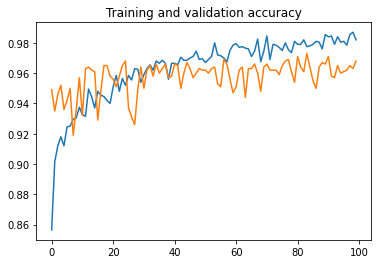

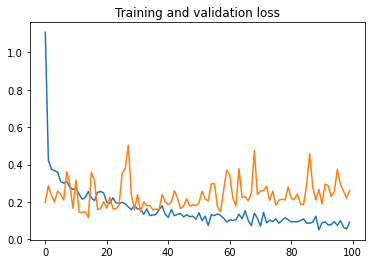

<Figure size 432x288 with 0 Axes>

In [12]:
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

#get number of epochs
epochs = range(len(acc))

#plot training and validation accuaracy per epoch
plt.plot(epochs,acc)
plt.plot(epochs,val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.title('Training and validation loss')
plt.figure()

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

**An approach where we do not use all the layers in the pre-trained model**

In [14]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [15]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

last layer output shape:  (None, 7, 7, 768)
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 - 20s - loss: 0.3718 - acc: 0.8565 - val_loss: 0.1187 - val_acc: 0.9590
Epoch 2/100
100/100 - 17s - loss: 0.2150 - acc: 0.9115 - val_loss: 0.0965 - val_acc: 0.9630
Epoch 3/100
100/100 - 16s - loss: 0.1970 - acc: 0.9225 - val_loss: 0.1170 - val_acc: 0.9620
Epoch 4/100
100/100 - 17s - loss: 0.1894 - acc: 0.9315 - val_loss: 0.2023 - val_acc: 0.9410
Epoch 5/100
100/100 - 16s - loss: 0.2062 - acc: 0.9265 - val_loss: 0.0957 - val_acc: 0.9650
Epoch 6/100
100/100 - 17s - loss: 0.1599 - acc: 0.9360 - val_loss: 0.1140 - val_acc: 0.9640
Epoch 7/100
100/100 - 16s - loss: 0.1757 - acc: 0.9375 - val_loss: 0.1157 - val_acc: 0.9600
Epoch 8/100
100/100 - 16s - loss: 0.1593 - acc: 0.9415 - val_loss: 0.1261 - val_acc: 0.9600
Epoch 9/100
100/100 - 16s - loss: 0.1909 - acc: 0.9425 - val_loss: 0.1242 - val_acc: 0.9590
Epoch 10/100
100/100 - 17s - loss: 0.1463 - acc: 0.9485 - val_loss: 0.1230 - val_acc: 0.9620
Epoch 11/100
100/100 - 16s - loss: 0.1648 - acc: 0.9390 - val_loss: 0.1058 - va

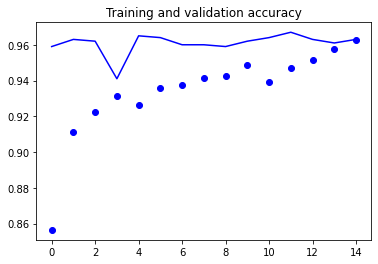

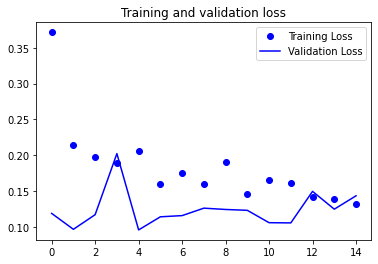

In [16]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving dog.jpg to dog.jpg
[0.]
dog.jpg is a cat
